# Part 5: The Generalized Bias-Variance Tradeoff & Double Descent
**A Non-Linear Programming Capstone Project**

## 1. Notebook Objective & Theoretical Framework
This final notebook synthesizes the analytical methods (Part 2), regularization theory (Part 3), and optimization behavior (Part 4) to demonstrate the **Double Descent** phenomenon.

We will move beyond the "single dataset" view and adopt the statistical learning perspective (ISL Ch. 2 and Ch. 10.8). By simulating thousands of parallel universes (datasets), we will empirically decompose the Mean Squared Error into **Bias² + Variance + Irreducible Error**.

**Core Hypothesis (based on *Schaeffer et al.* & *ISL*):**
The "descent" in the over-parameterized regime ($p > n$) occurs because, among the infinite solutions that satisfy $X\beta = y$, the "natural" solver (the Moore-Penrose Pseudoinverse or Gradient Descent initialized at zero) selects the solution with the **minimum $\ell_2$ norm**. This acts as an *implicit* regularization, suppressing the variance that explodes at the interpolation threshold.

### Block 1: The Experimental Design (The Ensemble Generator)
**Goal:** Define the infrastructure to calculate "True" Bias and Variance.

* **Concept:** To measure bias and variance, we cannot use a single training set. We must approximate the expectation over the data distribution $\mathbb{E}_{\mathcal{D}}$.
* **Implementation Details:**
    * Define a `true_function(x)`: $f(x) = \sin(2\pi x)$ or the previous $0.5x^2$.
    * Create a factory function that generates $K$ distinct datasets (e.g., $K=100$), each with $N$ sample points (e.g., $N=15$).
    * **PyTorch/Einsum:** Use broadcasting to generate all $K$ datasets in a single tensor operation for efficiency.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ---- numerical stability settings ----
torch.manual_seed(42)
np.random.seed(42)
torch.set_default_dtype(torch.float64)   # <-- use double precision globally


In [2]:
# ---- Switches (change these to toggle) ----
FUNCTION = "quadratic"   # options: "quadratic", "sine"
BASIS    = "power"    # options: "power", "legendre"

# Experiment sizes
K_datasets = 1000   # number of datasets (for E_D[·])
N_samples  = 15     # samples per dataset (interp. threshold at degree d = N_samples - 1)
sigma_noise = 0.2   # irreducible noise (std)
test_size   = 1000  # dense test grid

# True function selector
def true_function(x):
    if FUNCTION == "quadratic":
        return 0.5 * x**2
    elif FUNCTION == "sine":
        return torch.sin(2 * torch.pi * x)
    else:
        raise ValueError(f"Unknown FUNCTION={FUNCTION}")

# Data generator (Block 1)
def generate_ensemble(K, N, sigma):
    X = torch.rand(K, N) * 2 - 1       # U[-1,1]
    y = true_function(X) + sigma*torch.randn(K, N)
    return X, y

# Fixed test grid shared by all models
X_test = torch.linspace(-1, 1, test_size).view(-1, 1)
y_test_true = true_function(X_test)
print(f"[Config] FUNCTION={FUNCTION}, BASIS={BASIS}, K={K_datasets}, N={N_samples}, dtype={torch.get_default_dtype()}")


[Config] FUNCTION=quadratic, BASIS=power, K=1000, N=15, dtype=torch.float64


### Block 2: The Solver & The Minimum Norm Solution
**Goal:** Define the fitting mechanism that operates across both regimes.

* **Concept:** We need a solver that works for $p < n$ (Classical) and $p > n$ (Over-parameterized).
* **Mathematical Rigor:**
    * For $p \le n$ (Under-parameterized): The solution is unique (if $X$ is full rank). $\hat{\beta} = (X^T X)^{-1} X^T y$.
    * For $p > n$ (Over-parameterized): The system is underdetermined. There are infinite solutions. We explicitly choose the **Minimum Norm Solution**: $\hat{\beta} = X^T (X X^T)^{-1} y$ (using the pseudoinverse definition).
* **Implementation:** A function taking degree $d$ and the dataset, constructing the Vandermonde matrix via `einsum`, and solving via `torch.linalg.pinv`.

In [3]:
# ===== Step 2: Basis builders + unified minimum-norm solver (Block 2) =====

def legendre_basis(x, degree):
    """
    Legendre basis [P0..Pd] via recurrence on x in [-1,1].
    Works for x shaped (...), returns Phi shaped (..., d+1).
    """
    # ensure shape broadcastable
    P0 = torch.ones_like(x)
    if degree == 0:
        return P0.unsqueeze(-1)
    P1 = x
    Ps = [P0, P1]
    for n in range(2, degree + 1):
        Pn = ((2*n - 1) * x * Ps[-1] - (n - 1) * Ps[-2]) / n
        Ps.append(Pn)
    return torch.stack(Ps[:degree+1], dim=-1)

def power_basis(x, degree):
    """
    Vandermonde/power basis [x^0 .. x^d].
    x can be shape (K,N) or (N,) etc. Returns (..., d+1).
    """
    powers = torch.arange(degree + 1, dtype=torch.get_default_dtype())
    return x.unsqueeze(-1) ** powers

def make_basis(X, degree, basis_name):
    """
    X: (K,N) or (N,) tensor in [-1,1]
    Return Phi: (..., d+1) with chosen basis.
    """
    if basis_name == "power":
        return power_basis(X, degree)
    elif basis_name == "legendre":
        return legendre_basis(X, degree)
    else:
        raise ValueError(f"Unknown BASIS={basis_name}")

def fit_ensemble(X_train_ensemble, y_train_ensemble, degree, basis_name, rcond=1e-6):
    """
    Minimum-norm LS for all K datasets at once:
      betas = Phi^+ y
    X_train_ensemble: (K,N)
    y_train_ensemble: (K,N)
    Phi:               (K,N,d+1)   (built per chosen basis)
    Returns betas:     (K,d+1)
    """
    Phi = make_basis(X_train_ensemble, degree, basis_name)     # (K,N,d+1)
    Phi_pinv = torch.linalg.pinv(Phi, rcond=rcond)             # stable pseudoinverse
    betas = torch.matmul(Phi_pinv, y_train_ensemble.unsqueeze(-1))
    return betas.squeeze(-1)                                   # (K,d+1)


### Block 3: The Large-Scale Experiment (The Loop)
**Goal:** Collect error metrics across the complexity spectrum.

* **Methodology:**
    * Iterate through model degrees $d$ from 1 to n.
    * For each degree $d$:
        1.  Fit models to all $K$ datasets simultaneously.
        2.  Evaluate predictions on a large, fixed **Test Set**.
        3.  Calculate **Bias²**: $(\mathbb{E}[\hat{f}(x)] - f(x))^2$.
        4.  Calculate **Variance**: $\mathbb{E}[(\hat{f}(x) - \mathbb{E}[\hat{f}(x)])^2]$.
        5.  Calculate **MSE**: Bias² + Variance + Noise.
    * **Efficiency:** Heavily vectorized operations using Einstein summation.

In [4]:
# ===== Step 3: Experiment loop (Block 3) =====
degrees = range(1, 81)   # Legendre is stable well past 80; power may explode > ~40

bias_squared_history = []
variance_history     = []
mse_history          = []
avg_norm_history     = []

# Generate K datasets once
X_train_K, y_train_K = generate_ensemble(K_datasets, N_samples, sigma_noise)

print(f"[Loop] Starting Double Descent (basis={BASIS}, function={FUNCTION}) ...")
for d in degrees:
    # 1) fit all K models
    betas = fit_ensemble(X_train_K, y_train_K, d, basis_name=BASIS, rcond=1e-6)

    # 2) parameter norms (exclude intercept optional)
    avg_norm = torch.mean(torch.norm(betas, p=2, dim=1)).item()
    avg_norm_history.append(avg_norm)

    # 3) test basis (T, d+1)
    Phi_test = make_basis(X_test.squeeze(-1), d, basis_name=BASIS)

    # 4) predictions over K (K,T) = (K,d+1) @ (d+1,T)
    y_preds = torch.matmul(betas, Phi_test.T)

    # 5) bias-variance decomposition (population-style variance)
    main_pred = torch.mean(y_preds, dim=0)  # (T,)
    bias_sq   = torch.mean((main_pred.unsqueeze(-1) - y_test_true) ** 2).item()
    variance  = torch.mean(torch.var(y_preds, dim=0, unbiased=False)).item()
    mse       = torch.mean((y_preds - y_test_true.T) ** 2).item()

    bias_squared_history.append(bias_sq)
    variance_history.append(variance)
    mse_history.append(mse)

    if d % 10 == 0:
        print(f"  degree {d:3d}: MSE={mse:.4f}, Bias²={bias_sq:.4f}, Var={variance:.4f}")
print("[Loop] Done.")


[Loop] Starting Double Descent (basis=power, function=quadratic) ...
  degree  10: MSE=377489.6213, Bias²=217.1392, Var=377272.4821
  degree  20: MSE=2495500.7254, Bias²=1893.9982, Var=2493606.7272
  degree  30: MSE=4546813.4456, Bias²=176.3293, Var=4546637.1163
  degree  40: MSE=5729613.5139, Bias²=1303.5742, Var=5728309.9397
  degree  50: MSE=6439610.9854, Bias²=1768.6747, Var=6437842.3107
  degree  60: MSE=7029918.7357, Bias²=2640.8098, Var=7027277.9259
  degree  70: MSE=7324784.0670, Bias²=2732.0653, Var=7322052.0016
  degree  80: MSE=7482151.9989, Bias²=2501.5362, Var=7479650.4627
[Loop] Done.


### Block 4: Visualization of the Double Descent
**Goal:** The "Money Plot" (reproducing the YouTube video and ISL Figure 10.24).

* **Visuals:** A single figure with three overlaid curves:
    1.  **Bias² (Monotonic Decrease)**
    2.  **Variance (The Bell Curve)**
    3.  **Test Error (The Double Descent)**
* **Annotation:** Explicitly mark the **Interpolation Threshold** ($p=n$).

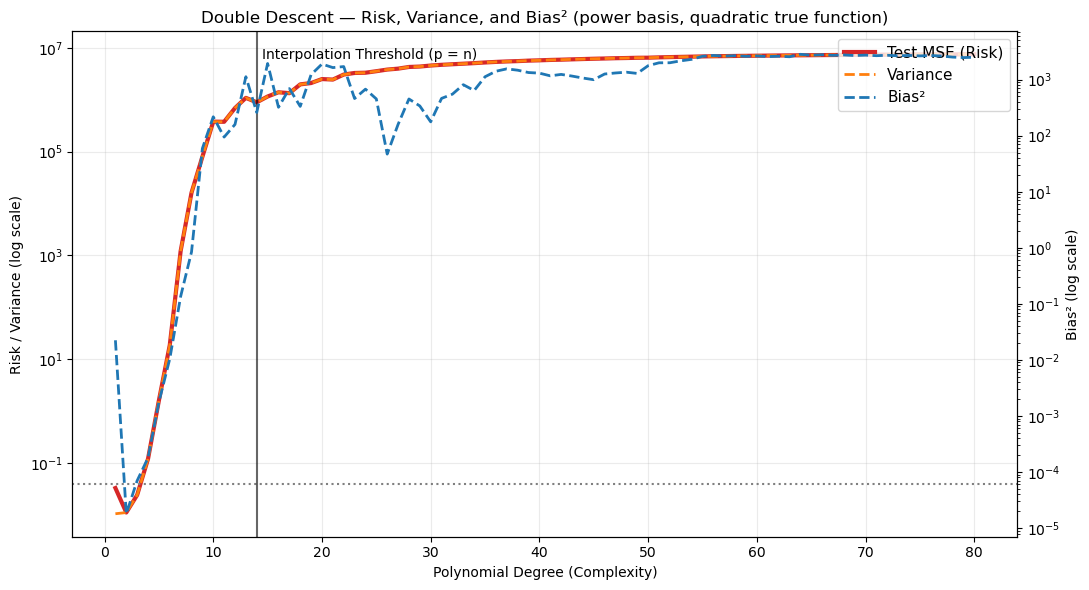

In [5]:
# ===== Block 4: Risk + Variance (left) and Bias² (right), both log scales =====
import numpy as np
import matplotlib.pyplot as plt

# Rebuild degree axis if not defined
if 'degrees' not in globals():
    degrees = range(1, len(mse_history) + 1)

degrees_np = np.array(list(degrees))
mse_np  = np.asarray(mse_history, dtype=float)
var_np  = np.asarray(variance_history, dtype=float)
bias_np = np.asarray(bias_squared_history, dtype=float)

def _clean(a):
    a = np.asarray(a, dtype=float)
    if not np.any(np.isfinite(a)):
        return np.ones_like(a)
    a = np.nan_to_num(a, nan=0.0, posinf=np.nanmax(a[np.isfinite(a)]))
    # avoid zeros on log axes
    a[a <= 0] = 1e-12
    return a

mse_np  = _clean(mse_np)
var_np  = _clean(var_np)
bias_np = _clean(bias_np)

threshold_degree = N_samples - 1

fig, ax1 = plt.subplots(figsize=(11, 6))

# --- Left axis (log): Risk + Variance ---
l_mse, = ax1.plot(degrees_np, mse_np,  label='Test MSE (Risk)', linewidth=3, color='tab:red')
l_var, = ax1.plot(degrees_np, var_np,  label='Variance',        linewidth=2, linestyle='--', color='tab:orange')
ax1.axhline(y=sigma_noise**2, linestyle=':', color='gray', label='Noise floor σ²')
ax1.axvline(x=threshold_degree, color='black', linestyle='-', alpha=0.6)

ax1.set_yscale('log')
ax1.set_xlabel('Polynomial Degree (Complexity)')
ax1.set_ylabel('Risk / Variance (log scale)')
ax1.grid(True, which='both', ls='-', alpha=0.25)

# --- Right axis (log): Bias² with its own scale (so it’s visible) ---
ax2 = ax1.twinx()
l_bias, = ax2.plot(degrees_np, bias_np, label='Bias²', linewidth=2, linestyle='--', color='tab:blue')
ax2.set_yscale('log')
ax2.set_ylabel('Bias² (log scale)')

# Optional: place the threshold label once
ax1.text(threshold_degree + 0.5, float(np.nanmax(mse_np))*0.8,
         'Interpolation Threshold (p = n)', fontsize=10)

# --- Combined legend (from both axes) ---
handles = [l_mse, l_var, l_bias]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, fontsize=11, loc='upper right')

plt.title(f'Double Descent — Risk, Variance, and Bias² ({BASIS} basis, {FUNCTION} true function)')
plt.tight_layout()
plt.show()


### Block 5: The Norm of the Parameters (Demystifying the Descent)
**Goal:** Prove *why* the test error drops in the modern regime.

* **Observation:** The norm will spike massively at $p=n$ (fighting to fit noise with limited freedom) and *decrease* as $p$ increases (the "Minimum Norm" effect).
* **Conclusion:** In the over-parameterized regime, the extra dimensions allow the model to fit the training data perfectly while maintaining a *smaller* total vector norm than at the threshold.

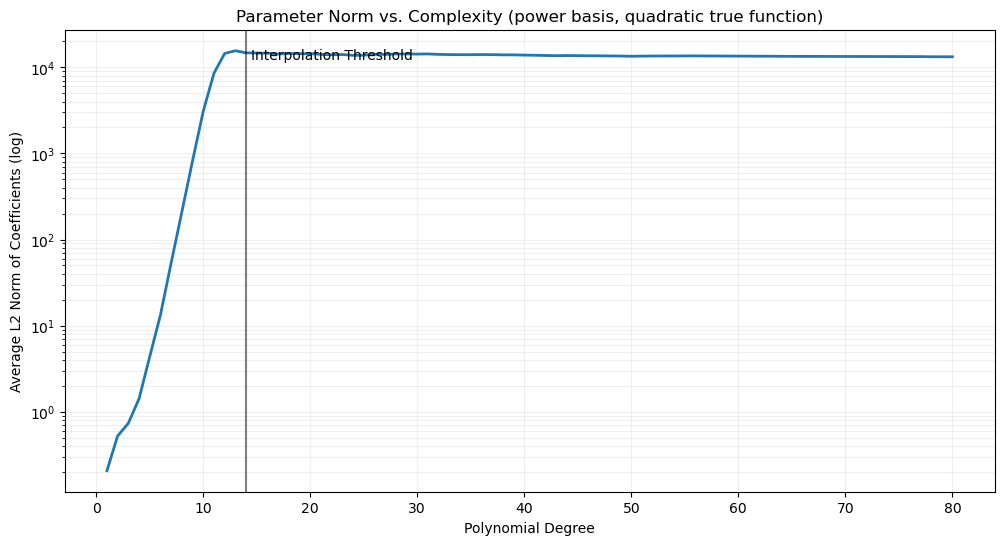

In [6]:
# ===== Step 5: Parameter norms vs complexity (Block 5) — agnostic =====
def plot_param_norms(degrees, avg_norm_history, N_samples, title='Parameter Norm vs. Complexity'):
    import numpy as np
    import matplotlib.pyplot as plt

    degrees_np = np.array(list(degrees))
    norms_np   = np.asarray(avg_norm_history, dtype=float)
    norms_np = np.nan_to_num(norms_np, nan=0.0, posinf=np.nanmax(norms_np[np.isfinite(norms_np)]) if np.any(np.isfinite(norms_np)) else 1.0)

    threshold_degree = N_samples - 1

    plt.figure(figsize=(12, 6))
    plt.plot(degrees_np, norms_np, linewidth=2)
    plt.axvline(x=threshold_degree, color='black', linestyle='-', alpha=0.5)
    plt.text(threshold_degree + 0.5, float(np.nanmax(norms_np))*0.8, 'Interpolation Threshold', fontsize=10)
    plt.yscale('log')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Average L2 Norm of Coefficients (log)')
    plt.title(title)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.show()

# Call it
plot_param_norms(
    degrees, avg_norm_history, N_samples,
    title=f'Parameter Norm vs. Complexity ({BASIS} basis, {FUNCTION} true function)'
)
